In [1]:
from pathlib import Path
from IPython.display import clear_output

from numpy import zeros, ones, expand_dims, hstack, sqrt, asarray
from numpy.random import randn, randint

import keras
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, LayerNormalization
from keras.layers import Conv2DTranspose, LeakyReLU, Activation, Input

import matplotlib.pyplot as plt

In [2]:
cwd = Path.cwd()
cwd

PosixPath('/Users/hamzz/Development/~professional/researchGAN')

In [3]:
def plot_data(data=None,
              n=5,
              figsize=(10, 8), 
              save=False, 
              name=None, path='/plot_data/',
              axis='on', show=False):

    images, labels = data
                  
    plt.figure(figsize=(figsize))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis(axis)
        plt.imshow(images[i].squeeze(), cmap='gray_r')
        if labels is not None:
            plt.title(CLASS_NAMES[labels[i].squeeze()], fontsize=14)
    plt.tight_layout()
    if save:
        while name is None:
            name = input("Enter name for figure: ")

        file_path = cwd / Path('figures') / Path(path)
        file_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(file_path.joinpath(str(name) + '.png'))
    if show:
        plt.show()
    plt.close()

In [4]:
def define_discriminator(n_cat, in_shape=(28, 28, 1)):
    # WEIGHT INITIALIZATION
    init = RandomNormal(stddev=0.02)

    # IMAGE INPUT
    in_image = Input(shape=in_shape)

    # DOWNSAMPLE -> (14x14)
    d = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same',
              kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.1)(d)

    # DOWNSAMPLE -> (7x7)
    d = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same',
              kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    # d = LayerNormalization()(d)

    # NORMAL
    d = Conv2D(filters=256, kernel_size=(4, 4), padding='same',
              kernel_initializer=init)(d)
    d = LeakyReLU(alpha=0.1)(d)
    # d = LayerNormalization()(d)

    # FLATTEN THE FEATURE MAPS
    d = Flatten()(d)

    # REAL / FAKE (OUTPUT)
    out_classifier = Dense(1, activation='sigmoid')(d)

    # DEFINE D MODEL
    d_model = Model(in_image, out_classifier)

    # COMPILE D MODEL
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    d_model.compile(loss='binary_crossentropy', optimizer=opt)

    # Q MODEL
    q = Dense(128)(d)
    # q = LayerNormalization()(q)
    q = LeakyReLU(alpha=0.1)(q)

    # Q MODEL (OUTPUT)
    out_codes = Dense(n_cat, activation='softmax')(q)

    # DEFINE Q MODEL
    q_model = Model(in_image, out_codes)
    return d_model, q_model

In [5]:
def define_generator(gen_input_size):
    # WEIGHT INITIALIZATION
    init = RandomNormal(stddev=0.02)

    # IMAGE GENERATOR INPUT
    in_lat = Input(shape=(gen_input_size))

    # FOUNDATION FOR 7x7 IMAGE
    n_nodes = 512 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    # gen = LayerNormalization()(gen)
    gen = Reshape((7, 7, 512))(gen)

    # NORMAL
    gen = Conv2D(filters=128, kernel_size=(4, 4), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    # gen = LayerNormalization()(gen)

    # UPSAMPLE 14x14
    gen = Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(gen)
    gen = Activation('relu')(gen)
    # gen = LayerNormalization()(gen)

    # UPSAMPLE 28x28
    gen = Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(gen)

    # TANH (OUTPUT)
    out_layer = Activation('tanh')(gen)

    # DEFINE MODEL
    g_model = Model(in_lat, out_layer)

    return g_model

In [6]:
def define_gan(g_model, d_model, q_model):
    # MAKE WEIGHTS IN THE DISCRIMINATOR AS NOT TRAINABLE
    d_model.trainable = False

    # CONNECT G OUTPUTS TO D INPUTS
    d_output = d_model(g_model.output)

    # CONNECT G OUTPUTS TO Q INPUTS
    q_output = q_model(g_model.output)

    # DEFINE COMPOSITE MODEL
    model = Model(g_model.input, [d_output, q_output])

    # COMPILE MODEL
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    
    return model

In [7]:
def load_real_samples(dataset=mnist):
    (X_train, _), (_, _) = dataset.load_data()
    # EXPAND TO 3D
    X = expand_dims(X_train, axis=-1)
    X = X.astype('float32')
    # SCALE FROM [0, 255] to [-1, 1]
    X = ((X - 127.5) / 127.5)
    return X

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return (X, y)

In [9]:
def generate_latent_points(latent_dim, n_cat, n_samples):
    z_latent = randn(latent_dim * n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)

    # GENERATE CATEGORICAL CODES
    cat_codes = randint(0, n_cat, n_samples)
    cat_codes = to_categorical(cat_codes, num_classes=n_cat)

    # CONCATENATE LATENT POINTS AND CONTROL CODES
    z_input = hstack((z_latent, cat_codes))
    
    return [z_input, cat_codes]

In [10]:
def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
    z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)

    # PREDICT OUTPUTS
    images = generator.predict(z_input)

    # CREATE CLASS LABELS
    y = zeros((n_samples, 1))

    return images, y

In [11]:
def save_plot(data, epoch, path=None):
    plot_data(data=data, save=True, axis='off', path=path, name=f'gen_image_e-{epoch+1:03d}')

In [12]:
def save_model(g_model, gan_model, epoch, path=None):
    file_path = cwd / Path('models') / Path(path)
    file_path.mkdir(parents=True, exist_ok=True)
    
    g_model.save(file_path / f'g_model_e-{epoch+1:03d}.h5')
    g_model.save(file_path / f'gan_model_e-{epoch+1:03d}.h5')

In [13]:
def summarise_performance(epoch, g_model, gan_model, latent_dim, n_cat, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_cat, n_samples)

    # SCALE FROM [-1, 1] TO [0, 1]
    X = (X + 1) / 2.0

    save_plot((X, None), epoch, path=f'{GAN_NAME}')
    save_model(g_model, gan_model, epoch, path=f'{GAN_NAME}')

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epoch = dataset[0].shape[0] // n_batch
    half_batch = n_batch // 2
    for i in range(n_epochs):
        for j in range(bat_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            
            g_loss, _ = gan_model.train_on_batch([z_input, labels_input], y_gan)

            print(f">[{i+1:03d}/{n_epochs}] | Batch: [{j+1:03d}/{bat_per_epoch:03d}] | D-Real: {d_loss1:.3f} | D-Fake: {d_loss2:.3f} | G: {g_loss:.3f}")

            if j % 30 == 0:
                clear_output(wait=True)
        summarise_performance(i, g_model, latent_dim)

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=100, n_batch=128):
    batch_per_epoch = dataset.shape[0] // n_batch
    half_batch = n_batch // 2

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # -------------------
            # TRAIN DISCRIMINATOR
            # -------------------
    
            # TRAIN ON REAL DATA
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1 = d_model.train_on_batch(X_real, y_real)
    
            # TRAIN ON FAKE DATA
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    
            # PREPARE POINTS IN LATENT SPACE FOR INPUT TO THE GENERATOR
            z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
            # CREATE INVERTED LABELS FOR THE FAKE SAMPLES
            y_gan = ones((n_batch, 1))
    
            # UPDATE THE GENERATOR VIA THE D AND Q ERROR
            _, g_1, g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])

            print(f">[{i+1:03d}/{n_epochs}] | Batch: [{j+1:03d}/{batch_per_epoch:03d}] | D: [{d_loss1:.3f}, {d_loss2:.3f}] | G: {g_1:.3f} | Q: {g_2:.3f}")
    
            if j % 30 == 0:
                clear_output(wait=True)
        summarise_performance(i, g_model, gan_model, latent_dim, n_cat)

In [16]:
n_cat = 10
latent_dim = 100

d_model, q_model = define_discriminator(n_cat)

gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)

gan_model = define_gan(g_model, d_model, q_model)
dataset = load_real_samples(dataset=mnist)

GAN_NAME = 'INFO-GAN/mnist/nonorm'

/Users/hamzz/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [17]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=100)

2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [452/468] | D: [0.578, 0.589] | G: 1.274 | Q: 0.000
2/2 [==============================] - 0s 5ms/step
>[100/100] | Batch: [453/468] | D: [0.553, 0.503] | G: 1.148 | Q: 0.000
2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [454/468] | D: [0.514, 0.452] | G: 1.110 | Q: 0.000
2/2 [==============================] - 0s 3ms/step
>[100/100] | Batch: [455/468] | D: [0.520, 0.534] | G: 1.169 | Q: 0.000
2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [456/468] | D: [0.461, 0.591] | G: 1.293 | Q: 0.000
2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [457/468] | D: [0.701, 0.389] | G: 1.258 | Q: 0.000
2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [458/468] | D: [0.647, 0.505] | G: 1.141 | Q: 0.000
2/2 [==============================] - 0s 4ms/step
>[100/100] | Batch: [459/468] | D: [0.511, 0.520] | G: 1.115 | Q: 0.000
2/2 [===========

5/5 [==============================] - 0s 16ms/step


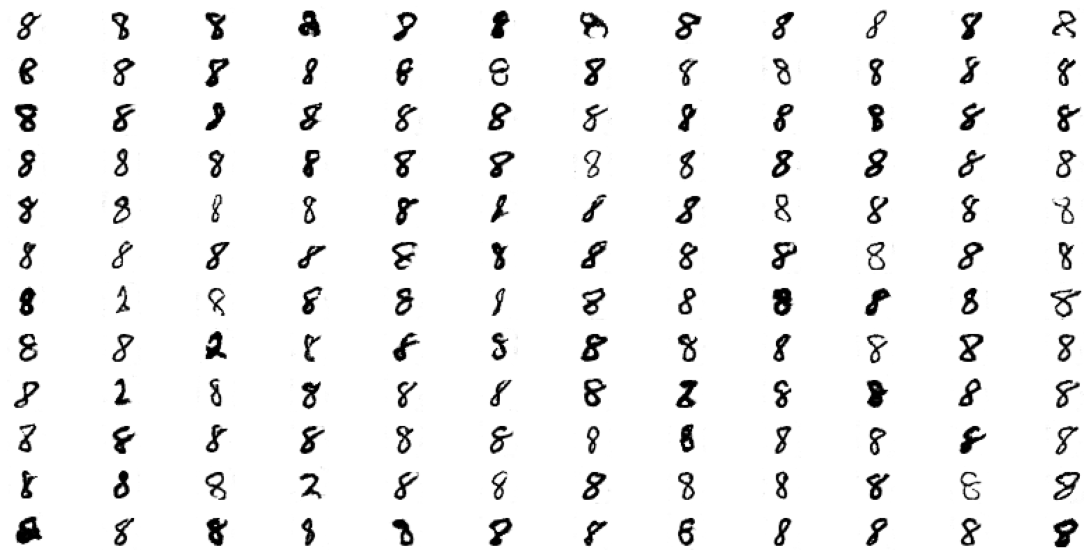

In [35]:
def generate_latent_points(latent_dim, n_cat, n_samples, digit):
    z_latent = randn(latent_dim * n_samples)
    z_latent = z_latent.reshape(n_samples, latent_dim)

    cat_codes = asarray([digit for _ in range(n_samples)])

    cat_codes = to_categorical(cat_codes, num_classes=n_cat)

    z_input = hstack((z_latent, cat_codes))
    return [z_input, cat_codes]

def plot_it(examples, n_examples):
    plt.figure(figsize=(20, 10))
    for i in range(n_examples):
        row, col = int(sqrt(n_examples)), int(sqrt(n_examples))
        plt.subplot(row, col, i+1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()


model = load_model(cwd.joinpath(f'models/{GAN_NAME}/g_model_e-100.h5'))
n_cat = 10
latent_dim = 100
n_samples = 144
digit = 4

z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples, digit)

X = model.predict(z_input)
X = (X + 1) / 2.0

plot_it(X, n_samples)

In [31]:
dict = {
    0: 1,
    1: 9,
    2: 3,
    3: 0,
    4: 8,
    5: 7,
    6: 4,
    7: 1,
    8: 6,
    9: 5,
}

In [32]:
sorted(list(dict.values()))

[0, 1, 1, 3, 4, 5, 6, 7, 8, 9]